# This notebook compares DP, CDP, RDP and tCDP

One very frustrating moment for beginners to start learning differential privacy is when they realize that there are all these different variants of definition and relaxation of DP. Among thetse relaxations, are the two popular definitions on concentrated differential privacy (CDP) and Renyi differential privacy (RDP).

A productive way of thinking about these new definitions is to treat them as intermediate tools, to arrive at a more interpretable --- $(\epsilon,\delta)$-DP. This is especially useful when we compose over many rounds of differentially private data access, in which case, the advanced technique for composition using CDP and RDP will often lead to a substantial improvement in the totoal privacy loss over the standard methods based on composing $(\epsilon,\delta)$-DP.




## Definitions

Let $X,X'$ be two datasets that differs by at most one data point. Let $\mathcal{A}$ be a randomized algorithm that takes in a dataset and output $o\in\mathcal{O}$ by sampling from a probability distribution supported on $\mathcal{O}$. Of course for any nontrivial algorithms, different input dataset induces a different probability distribution.

We say that $\mathcal{A}$ obeys $(\epsilon,\delta)$-DP, if for any neighboring datasets $X,X'$ and any measurable $S\subset \mathcal{O}$, it holds that
$$
P(\mathcal{A}(X) \in S) \leq e^\epsilon P(\mathcal{A}(X') \in S) + \delta.
$$

One can thinkg about DP as a concise summary of $\mathcal{A}$ using only $\epsilon,\delta$.  



Renyi Differential Privacy describes $\mathcal{A}$ more precisely using a function $\epsilon: (1,+\infty] \rightarrow \mathbb{R}_+$ such that the Renyi-divergence
$$D_\alpha(\mathcal{A}(X)\|\mathcal{A}(X'))\leq  \epsilon(\alpha)$$
for any $\alpha>1$.


$(\xi,\rho)$-Concentrated Differential Privacy (CDP) can be viewed as a concise approximation the RDP of $\mathcal{A}$ using a linear upper bound
$$
D_\alpha(\mathcal{A}(X)\|\mathcal{A}(X'))\leq  \xi + \rho\alpha.
$$

$(\xi,\rho,\tau)$-truncated CDP (tCDP) requires the linear upper bound of CDP to hold up to $\alpha \leq \tau$.



## RDP is in some sense a lossless representation of the randomized algorithm

It uses the Renyi divergences of all order $\alpha \geq 1$ to describe the randomized algorithm, which can be thought of as a characteristic function of the log-probability ratio.

CDP is a linear upper bound of the RDP.
* For Gaussian mechanism CDP is identical to RDP
* For Pure DP mechanisms (e.g., the Laplace Mechanism), we can produce a pretty good upper bound.

All these are implemented in ```autodp```.  The question si which one to use and when? In this notebook, we compare these techniques for privacy calibration and composition with the end-goal of achieving $(\epsilon,\delta)$-DP with a smallest possible $\delta$.


In [1]:
# Import package
from autodp import rdp_bank, rdp_acct, dp_acct,privacy_calibrator
import numpy as np
# declare the moment accountants
acct = rdp_acct.anaRDPacct()

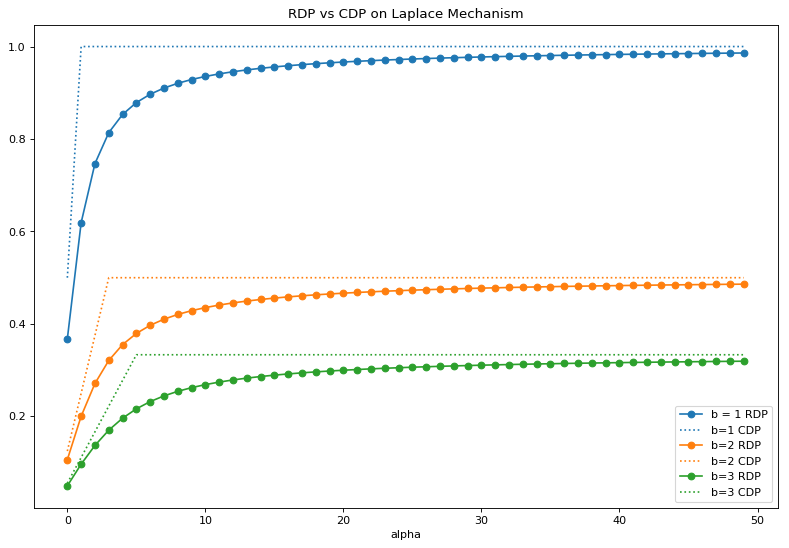

In [2]:
# Take Laplace mechanism for example, the corresponding CDP and RDP is the following:
import matplotlib.pyplot as plt
%matplotlib inline 

blist = [1,2,3]
rlist = []

ra_list = []


k=50

for b in blist:
    func_laplace = lambda x: rdp_bank.RDP_laplace({'b': b}, x)
    func_puredp = lambda x: rdp_bank.RDP_pureDP({'eps':1/b},x)

    results = [func_laplace(i+1) for i in range(k)]
    results1 = [func_puredp(i+1) for i in range(k)]
    rlist.append(results)
    ra_list.append(results1)
    
    
colorlist = ['C0', 'C1', 'C2','C3']
plt.figure(num=1, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')



for (item,item1,color) in zip(rlist,ra_list,colorlist):
    plt.plot(range(k), item,'-o',color=color)
    plt.plot(range(k),item1,':',color=color)

plt.legend(['b = 1 RDP','b=1 CDP','b=2 RDP','b=2 CDP', 'b=3 RDP','b=3 CDP'], loc='best')
plt.title('RDP vs CDP on Laplace Mechanism')
plt.xlabel('alpha')
plt.show()

In the above, the CDP is responsible only for the linearly increasing part of the bound and it will keep extrapolating linearly. 

## What about Gaussian mechanism

It turns out that for Gaussian mechanism, RDP, CDP and tCDP are identical. Since the RDP of Gaussian mechanism is 
$$
\epsilon(\alpha)  = \frac{\alpha}{2\sigma^2}
$$

## Experiments with Poisson Subsampled Gaussian mechanism

For subsampled gaussian mechanism,  there are multiple way of calculating its privacy guarantee, and all these approaches are made super easy by autodp.

1. Directly calculate the RDP of subsampled-gaussian mechanism. Then get $(\epsilon,\delta)$-DP by choosing $\delta$.
2. Calculate the tCDP bound for subsampled-gaussian mechanism according to the paper by Bun et al (2018). Then get $(\epsilon,\delta)$-DP by choosing $\delta$.
3. Find $(\epsilon',\delta/\gamma)$-DP for Gaussian mechanism using Analytical Gaussian mechanism, use the privacy amplification result to obtain the corresponding $(\epsilon,\delta)$-DP, with $\epsilon = \log(1+ \gamma(e^{\epsilon'}-1))$.

From the experiments in the paper, we can see that the tightest possible computation differs depending on the different parameter regimes.

In the following, we will illustrate the shape of the RDP as a function of $\alpha$ for a number of different choice of $\sigma$. 



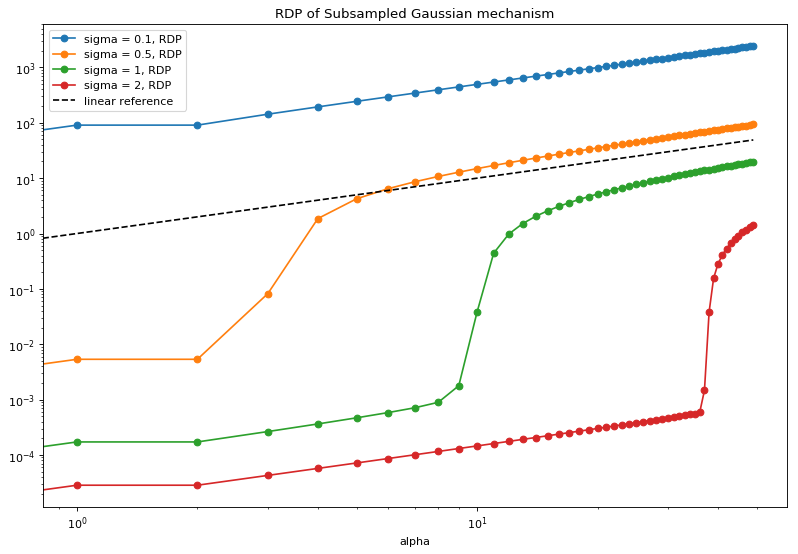

In [3]:
#  Code it up to show the comparison
sigma_list = [0.1,0.5,1,2]
prob = 0.01


glist = []



for sigma in sigma_list:
    func_gaussian= lambda x: rdp_bank.RDP_gaussian({'sigma': sigma }, x)
    # declare the moment accountants
    acct1 = rdp_acct.anaRDPacct()
    acct1.compose_poisson_subsampled_mechanisms(func_gaussian,prob)
    acct1.get_eps(delta=0.1)
    results = [acct1.evalRDP(1.0*i)  for i in range(k)]
    glist.append(results)


plt.figure(num=1, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

for (item,color) in zip(glist,colorlist):
    plt.loglog(range(k), item,'-o',color=color)
    #plt.plot(range(k),item1,':',color=color)

plt.loglog(range(k),range(k),'--k')
    
plt.legend(['sigma = 0.1, RDP','sigma = 0.5, RDP','sigma = 1, RDP','sigma = 2, RDP','linear reference'], loc='best')
plt.title('RDP of Subsampled Gaussian mechanism')
plt.xlabel('alpha')
plt.show()


As we can see, using RDP directly allows us to avoid the need of choosing parameters in tCDP, even though tCDP can potentially be used to a achieve a similar performance in the regime of interest. 